# Import packeges

In [6]:
import matplotlib.pyplot as plt
from utils import create_dataset,model_plot,history_plot, read_data, plot_data, prepare_train_test_data
import numpy as np
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression

In [7]:
clean_df, data = read_data('Totals.csv', debug=True)

         Date  Subscribers
0  2023-04-04            0
1  2023-04-05            0
2  2023-04-06            0
3  2023-04-07            0
4  2023-04-08            0
5  2023-04-09            0
6  2023-04-10            0
7  2023-04-11            0
8  2023-04-12            0
9  2023-04-13            0
----------------------------------------------------
        Date  Subscribers
0 2023-04-04            0
1 2023-04-05            0
2 2023-04-06            0
3 2023-04-07            0
4 2023-04-08            0
5 2023-04-09            0
6 2023-04-10            0
7 2023-04-11            0
8 2023-04-12            0
9 2023-04-13            0


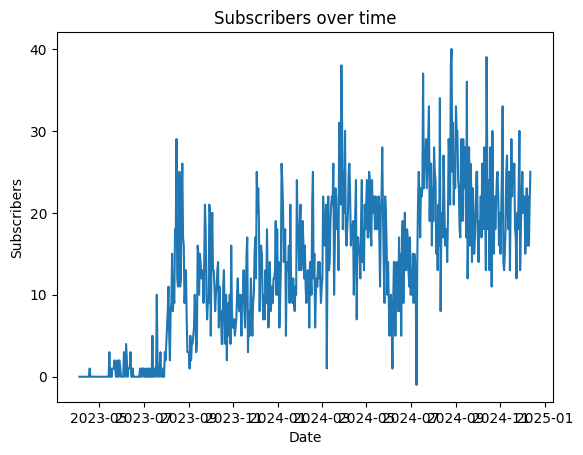

In [8]:
plot_data(clean_df["Subscribers"], title="Subscribers over time", x_label="Date", y_label="Subscribers")

In [9]:
def prepare_train_test_data(data, time_step_in, time_step_out, test_size=0.2):
    X, Y = create_dataset(data, time_step_in, time_step_out)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size)

    # Separate scalers for X and Y
    scaler_X = MinMaxScaler(feature_range=(0,1))
    scaler_Y = MinMaxScaler(feature_range=(0,1))
    x_train = scaler_X.fit_transform(X_train)
    y_train = scaler_Y.fit_transform(Y_train)
    x_test = scaler_X.transform(X_test)
    y_test = scaler_Y.transform(Y_test)

    print(f'x_train shape: {x_train.shape}, y_train shape: {y_train.shape}, x_test shape: {x_test.shape}, y_test shape: {y_test.shape}')
    
    return x_train, x_test, y_train, y_test, scaler_X, scaler_Y
x_train, x_test, y_train, y_test, scaler_X, scaler_Y = prepare_train_test_data(data, time_step_in=30, time_step_out=7, test_size=0.2)

x_train shape: (465, 30), y_train shape: (465, 7), x_test shape: (117, 30), y_test shape: (117, 7)


In [10]:
model=Sequential()
model.add(Dense(256,input_shape=(30,),activation="relu"))
model.add(Dense(128,activation="relu"))
model.add(Dense(64,activation="relu"))
model.add(Dense(32,activation="relu"))
model.add(Dense(7))
model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.001), metrics=['mean_absolute_error'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         7,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,399 (200.78 KB)

 Trainable params: 51,399 (200.78 KB)

 Non-trainable params: 0 (0.00 B)

# Cross Validation

In [12]:
tscv = TimeSeriesSplit(n_splits=5)
loss_total = []

for i, (train_index, test_index) in enumerate(tscv.split(x_train), 1):
    X_tr, X_val = x_train[train_index], x_train[test_index]
    y_tr, y_val = y_train[train_index], y_train[test_index]
    
    history = model.fit(
        X_tr, y_tr,  
        epochs=100, 
        validation_data=(X_val, y_val),  
        verbose=0  
    )
    
    y_pred = model.predict(X_val)
    loss = mean_absolute_error(y_val, y_pred)
    loss_total.append(loss)
    
  
    print(f"Fold {i}:")
    print(f"  Training data size: {X_tr.shape}")
    print(f"  Validation data size: {X_val.shape}")
    print(f"  MAE: {loss:.4f}")
    print("-" * 30)


mean_loss = np.mean(loss_total)
print(f'\nMean Loss (MAE) over all folds: {mean_loss:.4f}')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Fold 1:
  Training data size: (80, 30)
  Validation data size: (77, 30)
  MAE: 0.1205
------------------------------
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 2:
  Training data size: (157, 30)
  Validation data size: (77, 30)
  MAE: 0.1154
------------------------------
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Fold 3:
  Training data size: (234, 30)
  Validation data size: (77, 30)
  MAE: 0.1090
------------------------------
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Fold 4:
  Training data size: (311, 30)
  Validation data size: (77, 30)
  MAE: 0.1310
------------------------------
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 5:
  Training data size: (388, 30)
  Validation data size: (77, 30)
  MAE: 0.1165
------------------------------

Mean Loss (MAE) over all folds: 0.1185


In [13]:
all_predictions = []
input_window = x_test[-1]  

for i in range(1, 6): 
    print(f'Step {i} ==> Input Window: {input_window}')
    
    y_temp = model.predict(input_window.reshape(1, -1))
    print(f"Prediction Output (y_temp): {y_temp}")
    all_predictions.extend(y_temp[0])  # Add all predicted values from y_temp to the list
    input_window = np.roll(input_window, -1, axis=0)
    input_window[-1] = y_temp[0][0] 

Step 1 ==> Input Window: [0.4        0.85365854 0.2195122  0.46153846 0.51219512 0.43902439
 0.7        0.56097561 0.41463415 0.46341463 0.46341463 0.36585366
 0.48780488 0.725      0.68292683 0.53846154 0.97435897 1.025
 0.63414634 0.775      0.525      0.625      0.58536585 0.85
 0.75609756 0.75609756 0.625      0.58536585 0.46341463 0.43902439]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediction Output (y_temp): [[0.6673748  0.7033818  0.7222845  0.510945   0.5118184  0.737641
  0.48053673]]
Step 2 ==> Input Window: [0.85365854 0.2195122  0.46153846 0.51219512 0.43902439 0.7
 0.56097561 0.41463415 0.46341463 0.46341463 0.36585366 0.48780488
 0.725      0.68292683 0.53846154 0.97435897 1.025      0.63414634
 0.775      0.525      0.625      0.58536585 0.85       0.75609756
 0.75609756 0.625      0.58536585 0.46341463 0.43902439 0.66737479]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Prediction Output (y_temp): [[0.76895094 0.6396594  0.6037506  0.5756482  0.6156549  0.7568695
  0.67036927]]
S

In [14]:
all_predictions=np.array(all_predictions)

In [15]:
num_samples = len(all_predictions) // 7
all_predictions_reshaped = all_predictions.reshape(num_samples, 7)
y_next_30 = scaler_Y.inverse_transform(all_predictions_reshaped)
y_next_30=np.round(y_next_30)
print(y_next_30)

[[27. 28. 29. 20. 20. 29. 18.]
 [31. 25. 24. 23. 24. 29. 26.]
 [21. 23. 24. 22. 18. 15. 23.]
 [29. 24. 27. 24. 16. 39. 15.]
 [25. 22. 25. 15. 24. 28. 20.]]


In [16]:
x_test=scaler_X.inverse_transform(x_test)
x_train=scaler_X.inverse_transform(x_train)

In [17]:
x_test[-1]

array([16., 34.,  8., 18., 20., 17., 27., 22., 16., 18., 18., 14., 19.,
       29., 27., 21., 38., 40., 25., 31., 21., 25., 23., 33., 30., 30.,
       24., 23., 18., 17.])

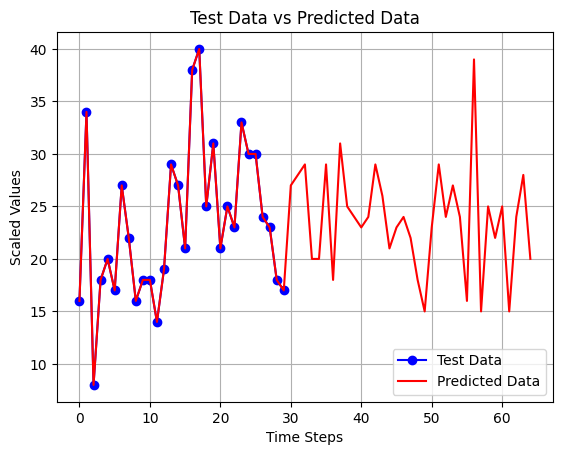

In [18]:
plt.plot(x_test[-1], label='Test Data', color='blue', marker='o')
plt.plot(np.hstack([x_test[-1], y_next_30.reshape(-1)]), label='Predicted Data', color='red')
plt.title('Test Data vs Predicted Data')
plt.xlabel('Time Steps')
plt.ylabel('Scaled Values')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
last_date = clean_df.index[-1]
total_sub = np.sum(np.array(clean_df['Subscribers']))
total_next_30 = np.sum(y_next_30)
print(f"Total subscribers till {last_date}: {total_sub}, next_30_days: {np.round(total_next_30)} => final after 30 days: {total_sub + round(total_next_30)}")

Total subscribers till 2024-12-12 00:00:00: 8117, next_30_days: 832.0 => final after 30 days: 8949


In [20]:
avg_sub = np.mean(np.array(clean_df['Subscribers']))
avg_sub * 30

393.3925686591276